# Задача
В этой работе вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week
 
Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

В этой задаче для обучения будут использовать 2 алгоритма:
 - [kNN](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

# Решение

Загрузите набор данных *data.adult.csv* с помощью `pandas` (скачать можно [здесь](https://drive.google.com/file/d/1Lo47fXx1RrJG3v9E-Gck1T45n5bJ_SJf/view?usp=sharing), или с помощью скрипта ниже). Чтобы лучше понимать, с чем вы работаете/корректно ли вы загрузили данные можно вывести несколько первых строк на экран.

<span style="color:orange">
Оранжевым будут отмечены ответы и подписи автора. <br/>
Ну поехали))

In [1]:
#!gdown 1Lo47fXx1RrJG3v9E-Gck1T45n5bJ_SJf

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import scikitplot 
import warnings
import shap 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import accuracy_score, f1_score, r2_score, make_scorer, classification_report, \
precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, StratifiedShuffleSplit, GridSearchCV
from sklearn.inspection import permutation_importance
import time


pd.options.mode.copy_on_write = True

In [2]:
data = pd.read_csv('data_adult.csv', delimiter=',')
print(data.shape)

(16280, 14)


In [3]:
print(data)

       age  workclass  fnlwgt     education  education-num  \
0       34  Local-gov  284843       HS-grad              9   
1       40    Private  190290  Some-college             10   
2       36  Local-gov  177858     Bachelors             13   
3       22    Private  184756  Some-college             10   
4       47    Private  149700     Bachelors             13   
...    ...        ...     ...           ...            ...   
16275   25  Local-gov  514716     Bachelors             13   
16276   32    Private  207668     Bachelors             13   
16277   27    Private  104457     Bachelors             13   
16278   59  State-gov  268700       HS-grad              9   
16279   33    Private   59083     Bachelors             13   

           marital-status         occupation   relationship  \
0           Never-married    Farming-fishing  Not-in-family   
1                Divorced              Sales  Not-in-family   
2      Married-civ-spouse     Prof-specialty      Own-child   
3  

In [4]:
print(data.describe())
print(data.info())

                age        fnlwgt  education-num  capital-gain  capital-loss  \
count  16280.000000  1.628000e+04   16280.000000  16280.000000  16280.000000   
mean      38.635074  1.894594e+05      10.098219   1020.417752     86.696314   
std       13.635301  1.066644e+05       2.567690   6862.041550    402.308715   
min       17.000000  1.930200e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.170068e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.781340e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.371630e+05      12.000000      0.000000      0.000000   
max       90.000000  1.484705e+06      16.000000  99999.000000   4356.000000   

       hours-per-week  
count    16280.000000  
mean        40.403686  
std         12.341191  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16280 entries

<span style="color:orange">
Итого на данный момент мы имеем 16280 строк и 14 признаков <br/>
Формат данных следующий: <br/>

Age: int \
workclass: str \
fnlwgt: int\
education: str\
education-num: int \
marital-status: str\
occupation: str\
relationship:str\
race: str\
sex: str\
capital-gain: int\
capital-loss: int \
hours-per-week: int\
'>50K,<=50K' : str\
</span>

## Анализ и предобработка данных

Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем: 
1. Проверьте есть ли в данных пропущенные значения (здесь они обозначены как "?"). Удалите из выборки все объекты с пропусками.
2. Выделите 60% выборки для обучения и дальнейшего анализа.
3. Обратите внимание, что не все признаки являются вещественными (числовыми). Сначала их необходимо проанализировать и по необходимости предобработать. Все шаги предобработки поясните текстом.
4. Целевую переменную (ту, которую мы хотим предсказывать) можно выделить в отдельную переменную и преобразуйте к бинарному формату (НЕ забудьте удалить ее из датасета, когда будете обучать модель).


In [5]:
df = data.copy()
mask_Null = (df[:] == '?')
number_Null = mask_Null.sum().sort_values(ascending=False)
print(number_Null)

print('\n')
print(df[df.duplicated()].size)

occupation        933
workclass         929
age                 0
fnlwgt              0
education           0
education-num       0
marital-status      0
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
>50K,<=50K          0
dtype: int64


168


<span style="color:orange">
Из данных видно, что примерно 1000 строк имеют пропуски.<br/>  
И присутствует 168 дублей.<br/> 
Почистим данные.<br/> 
Понятно, что сразу можно бинаризовать столбцы: sex, и таргет (>50K,<=50K), так как они двоичные.<br/>
Для поля 'sex' - 1 если мужчина, 0 если женщина.<br/>
Для поля '>50K,<=50K' - 1 если >50K, 0 если <=50K.<br/>
</span>

In [6]:
df = df.loc[(df['occupation'] != '?') & (df['workclass'] != '?')]
df.drop_duplicates(inplace=True, ignore_index=True)
print(df.shape)
df['sex'] = [1 if i == 'Male' else 0 for i in df['sex']]
df['>50K,<=50K'] = [1 if i == '>50K' else 0 for i in df['>50K,<=50K']]

mask_Null = (df[:] == '?')
number_Null = mask_Null.sum().sort_values(ascending=False)
print(number_Null)
print(df[df.duplicated()].size)
print(df)

(15335, 14)
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
>50K,<=50K        0
dtype: int64
0
       age  workclass  fnlwgt     education  education-num  \
0       34  Local-gov  284843       HS-grad              9   
1       40    Private  190290  Some-college             10   
2       36  Local-gov  177858     Bachelors             13   
3       22    Private  184756  Some-college             10   
4       47    Private  149700     Bachelors             13   
...    ...        ...     ...           ...            ...   
15330   25  Local-gov  514716     Bachelors             13   
15331   32    Private  207668     Bachelors             13   
15332   27    Private  104457     Bachelors             13   
15333   59  State-gov  268700       HS-grad              9   
15334   33 

<span style="color:orange">
После чистки пропусков осталось 15335 строк.<br/>   
Теперь необходимо преобразовать данные в числовой формат.<br/>   
Для этого рассмотрим на каком множестве значений находится каждый из признаков.<br/>    


In [7]:
column_names = df.columns.tolist()
for n in column_names:
    print(n)
    print(df[n].unique(), '\n')
    print('Size of the fiture is:', (df[n].unique()).size)
    print('MIN:', df[n].min())
    print('MAX', df[n].max())
    print('\n\n')

age
[34 40 36 22 47 18 31 25 53 19 44 20 28 35 38 30 37 64 41 42 33 48 60 43
 26 32 39 50 59 52 29 51 46 54 24 27 45 81 49 61 90 21 55 23 63 65 17 67
 57 72 58 56 62 80 76 68 71 75 74 66 70 69 78 79 73 85 88 77 83 84 86 82] 

Size of the fiture is: 72
MIN: 17
MAX 90



workclass
['Local-gov' 'Private' 'Federal-gov' 'Self-emp-inc' 'State-gov'
 'Self-emp-not-inc' 'Without-pay'] 

Size of the fiture is: 7
MIN: Federal-gov
MAX Without-pay



fnlwgt
[284843 190290 177858 ... 514716 104457 268700] 

Size of the fiture is: 12065
MIN: 19302
MAX 1484705



education
['HS-grad' 'Some-college' 'Bachelors' 'Assoc-acdm' '12th' 'Doctorate'
 '1st-4th' '7th-8th' 'Masters' '5th-6th' '11th' '9th' 'Assoc-voc'
 'Prof-school' '10th' 'Preschool'] 

Size of the fiture is: 16
MIN: 10th
MAX Some-college



education-num
[ 9 10 13 12  8 16  2  4 14  3  7  5 11 15  6  1] 

Size of the fiture is: 16
MIN: 1
MAX 16



marital-status
['Never-married' 'Divorced' 'Married-civ-spouse' 'Separated'
 'Married-spouse-absen

<span style="color:orange">
Теперь разобьём данные на трейновую и тестовую части для чистоты эксперимента, чтобы избежать утечек.<br/>
Дальше работаем только с train частью.<br/>
  

In [8]:
train, test = train_test_split(df, test_size= 0.4, random_state= 0)
ind_train = train.index.values
ind_test = test.index.values

print(train.shape)
print(train)
#print(ind_train)

(9201, 14)
       age         workclass  fnlwgt     education  education-num  \
7822    46           Private  150499    Assoc-acdm             12   
1066    69      Self-emp-inc  169717     Bachelors             13   
10356   26           Private  109570  Some-college             10   
11399   54           Private  326156  Some-college             10   
9551    49         Local-gov  215895       Masters             14   
...    ...               ...     ...           ...            ...   
13123   60           Private  175273       HS-grad              9   
3264    54         Local-gov  169785       Masters             14   
9845    32  Self-emp-not-inc  154950  Some-college             10   
10799   30           Private  143526     Bachelors             13   
2732    51           Private  230858  Some-college             10   

           marital-status         occupation relationship   race  sex  \
7822   Married-civ-spouse       Craft-repair      Husband  White    1   
1066   Married

<span style="color:orange">
Далее приведём графики вероятностей получения зарплаты выше 50K в зависимости от значений каждого из параметров по отдельности.<br/>


In [9]:
def show_df_data(train, name, flg='def'):
    work_list = {}
    for i in train[name].unique():
        n = train.loc[(train[name] == i) & (train['>50K,<=50K'] == 1)].shape[0] / \
        train.loc[(train[name] == i)].shape[0]
        work_list[i] = n   
    
    work_list = dict(sorted(work_list.items(), key=lambda item: item[1], reverse=True))
    #print(work_list)

    
    fig, ax = plt.subplots()
    y_pos = np.arange(len(work_list.keys()))
    val = list(work_list.values())
    ax.barh(y_pos, val)
    print(val)

    if(flg == 'l'):
        z = np.polyfit(y_pos, val, 1 )
        p = np.poly1d(z)
        plt.plot(p(y_pos), y_pos, color='orange') 
    
    ax.set_yticks(y_pos, labels=work_list.keys())
    plt.show()

[0.5, 0.48854961832061067, 0.4726027397260274, 0.46859903381642515, 0.44554455445544555, 0.4322916666666667, 0.41847826086956524, 0.41037735849056606, 0.4051724137931034, 0.4048582995951417, 0.4, 0.39823008849557523, 0.3950617283950617, 0.3941908713692946, 0.3925925925925926, 0.39111111111111113, 0.384297520661157, 0.38235294117647056, 0.37362637362637363, 0.36220472440944884, 0.36082474226804123, 0.3493975903614458, 0.3269230769230769, 0.3263598326359833, 0.32599118942731276, 0.3157894736842105, 0.30303030303030304, 0.3, 0.2926829268292683, 0.2908366533864542, 0.2846715328467153, 0.27530364372469635, 0.2608695652173913, 0.2602739726027397, 0.25, 0.22846441947565543, 0.2222222222222222, 0.22093023255813954, 0.21739130434782608, 0.21153846153846154, 0.2, 0.18775510204081633, 0.17647058823529413, 0.17391304347826086, 0.1724137931034483, 0.15384615384615385, 0.15, 0.1440329218106996, 0.14285714285714285, 0.125, 0.125, 0.1111111111111111, 0.1072961373390558, 0.08333333333333333, 0.08333333

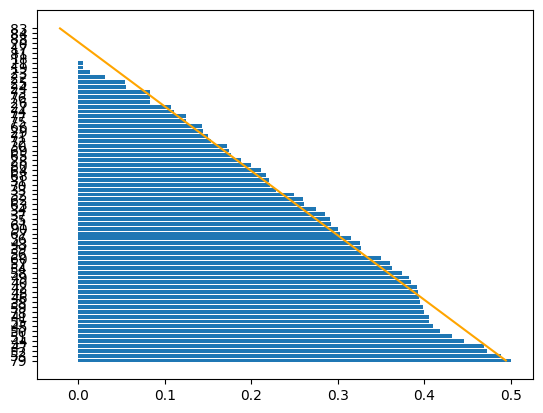

In [10]:
show_df_data(train, 'age', 'l')

[0.5522388059701493, 0.3942652329749104, 0.30200501253132833, 0.2953846153846154, 0.2914572864321608, 0.22891923990498814, 0.0]


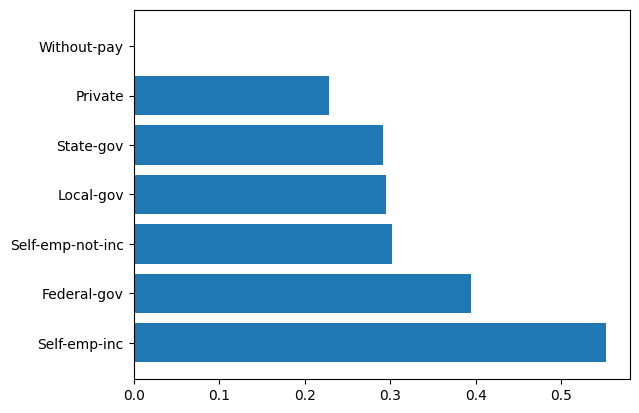

In [11]:
show_df_data(train, 'workclass')

[0.7704918032786885, 0.7672413793103449, 0.587037037037037, 0.43322475570032576, 0.2623762376237624, 0.2229965156794425, 0.20722057368941643, 0.17237903225806453, 0.09090909090909091, 0.08333333333333333, 0.0778688524590164, 0.05405405405405406, 0.0473186119873817, 0.044444444444444446, 0.03571428571428571, 0.0]


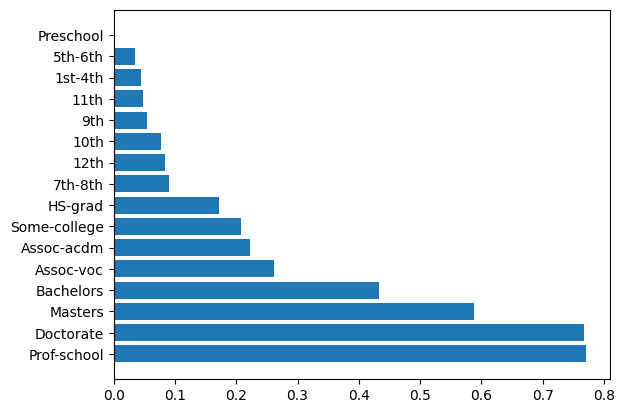

In [12]:
show_df_data(train, 'education')

[0.7704918032786885, 0.7672413793103449, 0.587037037037037, 0.43322475570032576, 0.2623762376237624, 0.2229965156794425, 0.20722057368941643, 0.17237903225806453, 0.09090909090909091, 0.08333333333333333, 0.0778688524590164, 0.05405405405405406, 0.0473186119873817, 0.044444444444444446, 0.03571428571428571, 0.0]


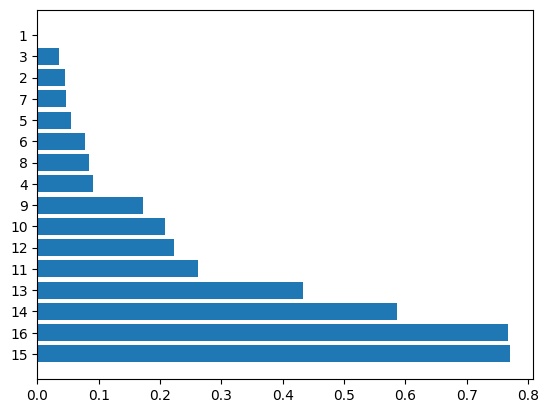

In [13]:
show_df_data(train, 'education-num')

[0.5, 0.4642857142857143, 0.11818181818181818, 0.10471622701838529, 0.08778625954198473, 0.06060606060606061, 0.054842068726136756]


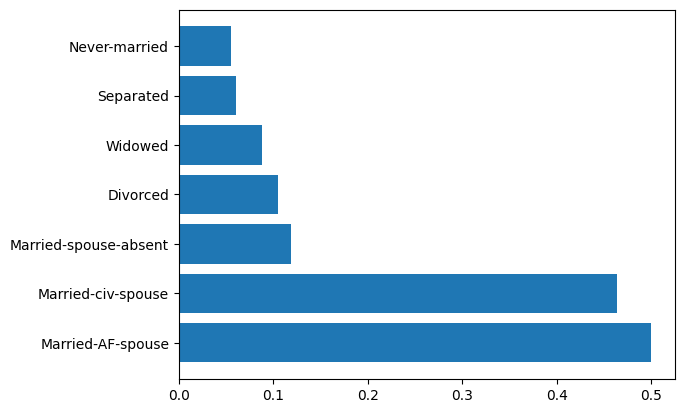

In [14]:
show_df_data(train, 'marital-status')

[0.501255230125523, 0.5, 0.46459824980111375, 0.35714285714285715, 0.3037037037037037, 0.28351449275362317, 0.24603174603174602, 0.19750519750519752, 0.13693693693693693, 0.13333333333333333, 0.11552346570397112, 0.05263157894736842, 0.04209445585215606, 0.016129032258064516]


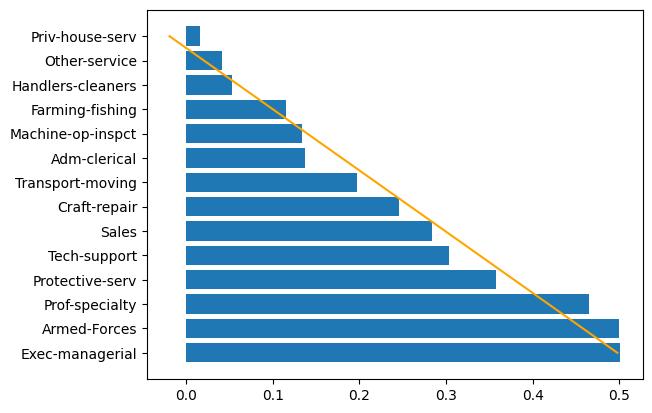

In [15]:
show_df_data(train, 'occupation', 'l')

[0.49676025917926564, 0.4664768314781258, 0.11515151515151516, 0.06387434554973823, 0.04247104247104247, 0.011843079200592153]


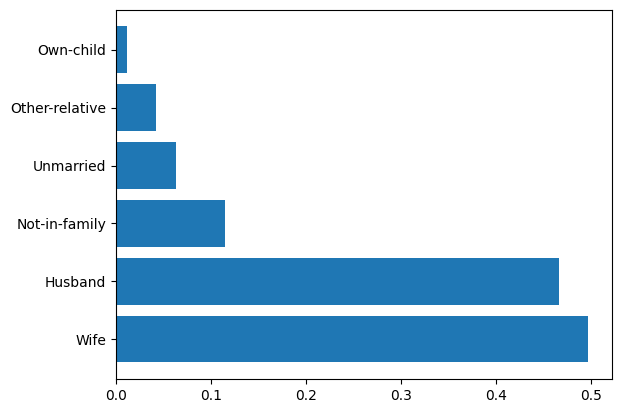

In [16]:
show_df_data(train, 'relationship')

[0.27699590583418626, 0.25838926174496646, 0.13733905579399142, 0.10843373493975904, 0.09722222222222222]


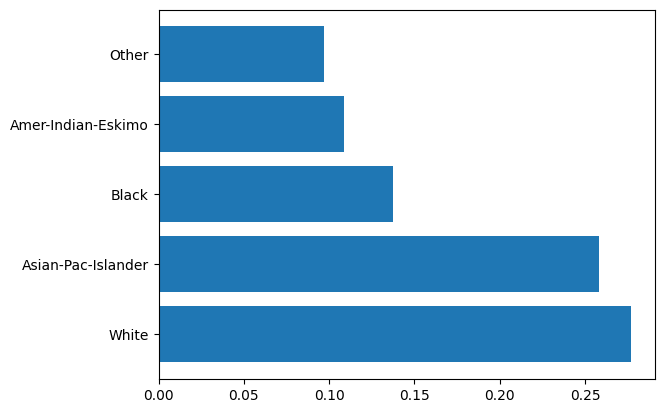

In [17]:
show_df_data(train, 'race')

При обучении алгоритмов стоит обращать внимание не только на их качество, но и каким образом они работают с данными. Давайте посмотрим на значения самих признаков.

Что можете сказать о разбросе данных и сбалансированности выборки? Какой из алгоритмов, на ваш взгляд окажется более качественным: логический или метрический? Почему?

<span style="color:orange">
Так как мы работаем с выборкой людей, есть наивное предположение, что она имеет кластерную структуру, так как люди склонны сбиваться в группы по интересам. Из этого предположения можно сделать вывод, что метрический алгоритм лучше. <br/>
Однако лучше обучить оба и посмотреть какой лучше.

## Добавление категориальных признаков

Добавим к предобработанным вещественным признакам категориальные. Но для начала их тоже необходимо предобработать.

Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) или [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) / [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) из sklearn).

После преобразования категориальных признаков, добавьте их к вещественным предобработанным данным для обучения.

>PS Напоминаю, что важно удалить колонку с целевым значением

<span style="color:orange">
    
## Вариант 1 
Преобразовать все катигориальные признаки посредствам обычного one-hot.

In [18]:
onehotencoder = OneHotEncoder(handle_unknown='error')

df_dencoder = pd.DataFrame(onehotencoder.fit_transform(df[['workclass', 'education', \
'marital-status', 'occupation', 'relationship', 'race']]).toarray())

encoded_columns_name = onehotencoder.get_feature_names_out(['workclass', 'education', \
'marital-status', 'occupation', 'relationship', 'race'])
dict_column_names = {}
for i in range(len(encoded_columns_name)):
    dict_column_names[i] = encoded_columns_name[i]
df_dencoder.rename(columns=dict_column_names, inplace=True)

In [19]:
df_enc = df.copy()
target = df['>50K,<=50K']
df_enc.drop(['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', \
'>50K,<=50K'], axis= 1 , inplace= True)

df_enc = df_enc.join(df_dencoder)

<span style="color:orange">
Разбиваем на Train и Test с теми же индексами, что и в начале файла, для предотвращения утечки данных.


In [20]:
X_train = df_enc.iloc[ind_train]
X_test = df_enc.iloc[ind_test]
y_train = target.iloc[ind_train]
y_test = target.iloc[ind_test]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

<span style="color:orange">
И применим метод T-SNE для визуализации данных. Причём применим StandardScaler. <br/>
Интересен следующий вопрос:<br/>
Можно ли утвеждать, что данные разделились на классы, над которыми удобно строить KNN?<br/>
На данный момент отвечу на него утвердительно.

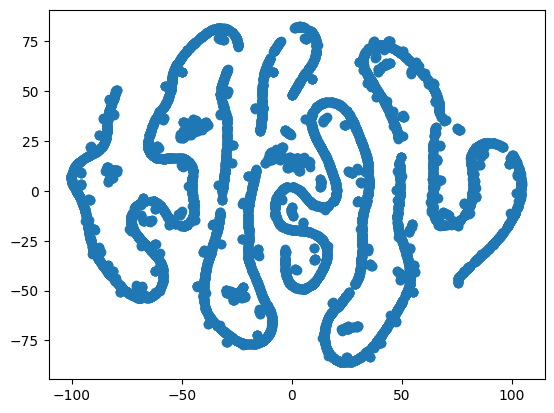

In [22]:
tsne = TSNE(random_state=17)
tsne_representation = tsne.fit_transform(X_train)
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1]);

<span style="color:orange">
Нешкалированные данные. <br/>
Видно, что области изолированы и растянуты.

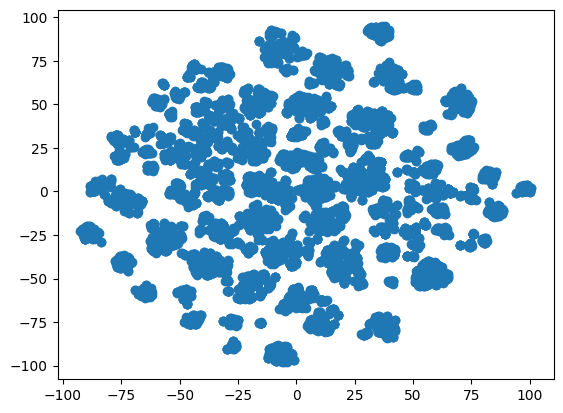

In [21]:
tsne = TSNE(random_state=17)
tsne_representation = tsne.fit_transform(X_train_scaled)
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1]);

<span style="color:orange">
Шкалированные данные. <br/>
Видно что облости локализировались.
Кажется что на шкалированных данных точность модели возрастёт.

## Обучение классификаторов

В начале посмотрим, как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 2 алгоритма:
 - [kNN](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

Для начала выберем один гиперпараметр, который будем оптимизировать:
 - kNN — число соседей (*n_neighbors*)
 - DecisonTree — глубина дерева (*max_depth*)
 
Остальные параметры оставляйте в значениях по умолчанию.

Для каждого алгоритма подберите оптимальные значения указанных гиперпараметров. Постройте график среднего значения качества по кросс-валидации алгоритма при заданном значении гиперпараметра, на котором также отобразите доверительный интервал.

Что вы можете сказать о получившихся графиках? Какой алгоритм справился лучше? Какой быстрее? Почему?

In [23]:
"Функция парсинга вывода RandomSearchCV"

def plot_res(score_res, b_par):
    if (list(score_res['params'][1].keys())[0] == 'n_neighbors'):
        name = 'n_neighbors'
    else:
        name = 'max_depth'
    
    dict_res = {}
    dict_min = {}
    dict_max = {}
    for i in range(len(score_res['params'])):
    #    list_res.append(score_res['params'][i]['n_neighbors'])
        dict_res[score_res['params'][i][name]] = score_res['mean_test_score'][i]
        dict_min[score_res['params'][i][name]] = score_res['mean_test_score'][i] - \
        score_res['std_test_score'][i]
        dict_max[score_res['params'][i][name]] = score_res['mean_test_score'][i] + \
        score_res['std_test_score'][i]
    
    dict_res = dict(sorted(dict_res.items()))
    dict_min = dict(sorted(dict_min.items()))
    dict_max = dict(sorted(dict_max.items()))

    plt.plot(dict_res.keys(), dict_res.values(), label='Avg')
    plt.plot(dict_min.keys(), dict_min.values(), label='Min')
    plt.plot(dict_max.keys(), dict_max.values(), label='Max')
    plt.legend(loc="upper right")
    plt.xlabel('N') #Подпись для оси х
    plt.ylabel('Score') #Подпись для оси y
    plt.title('Plot of Score for different N') #Название
    plt.show()

    print(b_par)
    bpar_ind = score_res['params'].index(b_par)
    print('Test score is:', score_res['mean_train_score'][bpar_ind])
    print('Time fit is:', score_res['mean_fit_time'][bpar_ind])

<span style="color:orange">
Построение модели KNN на нешкалированных признаках. Критерием качества будет f1 binary так как таргет
бинарный.

In [24]:
def KNN_train_res(X_train, y_train):
    knn_Knotscl = KNeighborsClassifier()
    
    hyper_param_knn_Knotscl = {
    'n_neighbors' : [1, 3, 4, 5, 7, 9, 12, 15, 17, 25, 30, 35]
    }
    clf_Knotscl = RandomizedSearchCV(knn_Knotscl, hyper_param_knn_Knotscl, cv=5, scoring='f1', return_train_score=True)
    search_Knotscl= clf_Knotscl.fit(X_train, y_train)
    b_par_Knotscl = search_Knotscl.best_params_
    score_res_Knotscl = search_Knotscl.cv_results_

    plot_res(score_res_Knotscl, b_par_Knotscl)

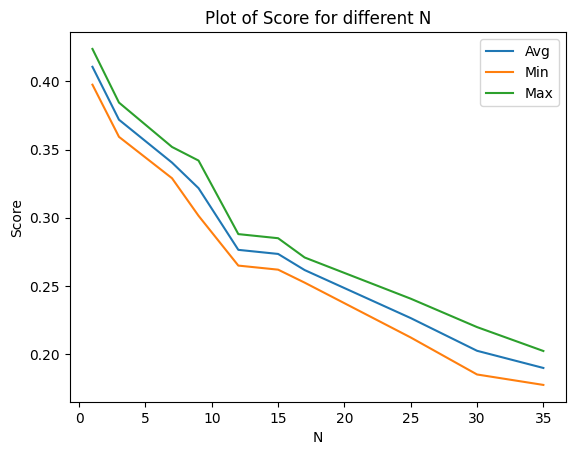

{'n_neighbors': 1}
Test score is: 1.0
Time fit is: 0.006106138229370117


In [25]:
KNN_train_res(X_train, y_train)

<span style="color:orange">
Построение модели KNN на шкалированных признаках:

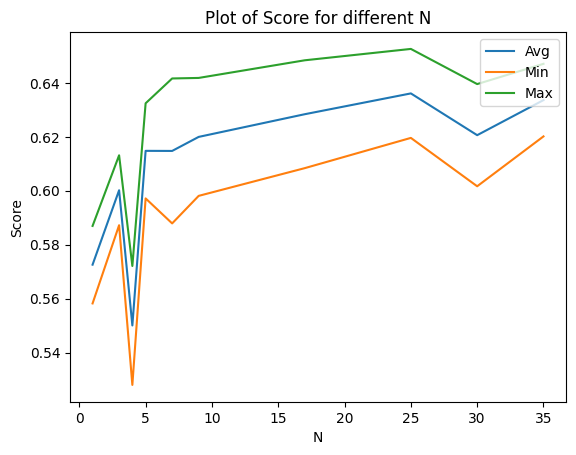

{'n_neighbors': 25}
Test score is: 0.6581411402198765
Time fit is: 0.0037322044372558594


In [26]:
KNN_train_res(X_train_scaled, y_train)

<span style="color:orange">
Построение модели Tree на нешкалированных признаках:

In [27]:
def TREE_train_res(X_train, y_train, flg=False):
    tree_Tnotscl = DecisionTreeClassifier(criterion='gini')
    
    hyper_param_tree_Tnotscl = {
    'max_depth' : [1, 2, 4, 6, 8, 10, 12, 14, 15, 20]
    }
    
    clf_Tnotscl = RandomizedSearchCV(tree_Tnotscl, hyper_param_tree_Tnotscl, cv=5, scoring='f1', return_train_score=True)
    search_Tnotscl = clf_Tnotscl.fit(X_train, y_train)
    b_par_Tnotscl = search_Tnotscl.best_params_
    score_res_Tnotscl = search_Tnotscl.cv_results_

    plot_res(score_res_Tnotscl, b_par_Tnotscl)

    if flg:
        return clf_Tnotscl

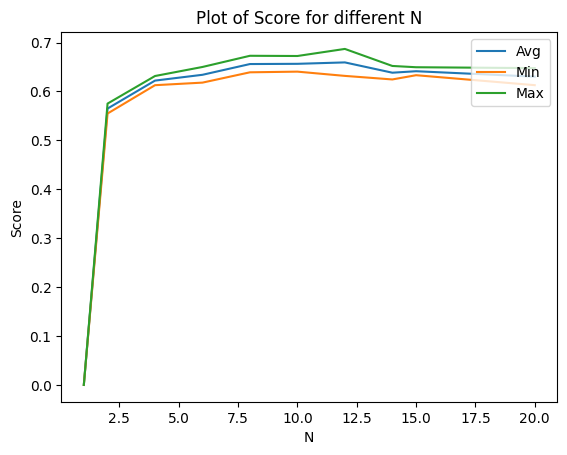

{'max_depth': 12}
Test score is: 0.7990088320076306
Time fit is: 0.03244924545288086


In [28]:
model_imp = TREE_train_res(X_train, y_train, flg=True)

<span style="color:orange">
Ради интереса изучим feture importances:

In [29]:
importances = model_imp.best_estimator_.feature_importances_
feat_name = model_imp.best_estimator_.feature_names_in_

dic = {}
for i in range(len(importances)):
    dic[feat_name[i]] = importances[i]
dic_sort = dict(sorted(dic.items(), key=lambda item: item[1], reverse=True))
print(dic_sort)

{'marital-status_Married-civ-spouse': 0.3201131564261118, 'education-num': 0.18428084943825054, 'capital-gain': 0.1450605282085156, 'age': 0.07552737058177786, 'fnlwgt': 0.051392042510064566, 'hours-per-week': 0.04834909853119358, 'capital-loss': 0.0413201476336867, 'occupation_Exec-managerial': 0.01424368496611999, 'workclass_Self-emp-not-inc': 0.013047548734725169, 'occupation_Adm-clerical': 0.0072061969608076355, 'sex': 0.005634059598879013, 'workclass_Private': 0.005612296500007013, 'occupation_Other-service': 0.005255493936277812, 'education_Masters': 0.004990812542183582, 'occupation_Sales': 0.0047926420433270795, 'occupation_Prof-specialty': 0.004714791966359331, 'race_White': 0.004616239697008878, 'workclass_Self-emp-inc': 0.004564636871880146, 'relationship_Husband': 0.004317383232840478, 'workclass_Local-gov': 0.004144332171620525, 'race_Asian-Pac-Islander': 0.003779732057697417, 'occupation_Transport-moving': 0.003622305471009346, 'relationship_Wife': 0.0035436979566825784, 

<span style="color:orange">
Первые 5 значений: <br/>
'marital-status_Married-civ-spouse': 0.31913308701985005 <br/>
'education-num': 0.1860334377724561 <br/>
'capital-gain': 0.14486479215182888 <br/>
'age': 0.07641396401869577 <br/>
'fnlwgt': 0.051187126569496436

<span style="color:orange">
Построение модели Tree на шкалированных признаках:

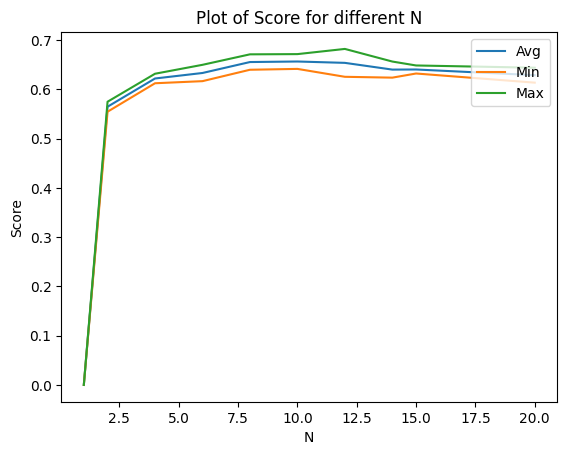

{'max_depth': 10}
Test score is: 0.7528569830551781
Time fit is: 0.028325796127319336


In [30]:
TREE_train_res(X_train_scaled, y_train)

<span style="color:orange">
    
### KNN ###
Работа с нешкалированными данными затруднена.
Оптимальное число соседей около 20 - 25. f1=0.658 на шкалированных данных. На графиках видна кривая 
переобучения.   


### TREE ###
Оптимальная глубина дерева 12. Score=0.798 на нешкалированных данных. Шкалирование мало меняет 
точность работы алгоритма и время. На графиках видна кривая переобучения.

### Итого ###
Дерево на нешкалированных данных справилось лучше всего. 
KNN справился хуже, притом время меньше на порядок по сравнению с деревом. <br/>
Оптимальная глубина дерева - 12. 

## PCA преобразование

Теперь попробуем сделать преобразрование данных с помощью PCA. Выберите оптимальное количество компонент и преобразуйте данные. Объясните свой выбор.

In [31]:
u, Rs, vh = np.linalg.svd(X_train, full_matrices=False)
u_s, Rs_s, vh_s = np.linalg.svd(X_train_scaled, full_matrices=False)
u_t, Rs_t, vh_t = np.linalg.svd(X_test, full_matrices=False)
u_ts, Rs_ts, vh_ts = np.linalg.svd(X_test_scaled, full_matrices=False)

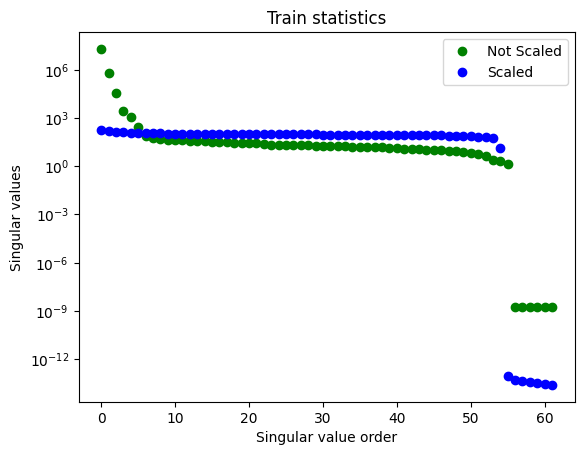

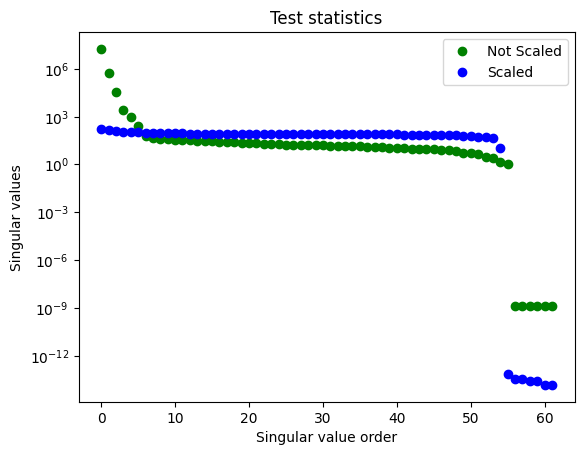

In [32]:
plt.plot(Rs,'go')
plt.plot(Rs_s,'bo')
plt.title('Train statistics')
plt.legend(['Not Scaled', 'Scaled'], loc='upper right')
plt.yscale('log')
plt.ylabel("Singular values")
plt.xlabel("Singular value order")
plt.show()

plt.plot(Rs_t,'go')
plt.plot(Rs_ts,'bo')
plt.title('Test statistics')
plt.legend(['Not Scaled', 'Scaled'], loc='upper right')
plt.yscale('log')
plt.ylabel("Singular values")
plt.xlabel("Singular value order")
plt.show()

<span style="color:orange">
Из графика видно, что можно убрать 6 сингулярных значений так как они малозначительны.
На самом деле можно убрать практически все признаки, давайте посмотрим на зависимость Score от K.

In [33]:
K_score = []
K_list = [1, 2, 3, 6, 12, 20, 40, 60]
for k in K_list:
    pca_1 = PCA(n_components=k)
    pca_1.fit(X_train)
    X_train_kdif = pca_1.transform(X_train)

    knn_Knotscl_pca = KNeighborsClassifier()
    
    hyper_param_knn_Knotscl_pca = {
    'n_neighbors' : [3, 5, 8, 12, 15, 25, 45, 70, 80, 120]
    }
    clf_Knotscl_pca = RandomizedSearchCV(knn_Knotscl_pca, hyper_param_knn_Knotscl_pca, cv=5, scoring='f1', return_train_score=True)
    search_Knotscl_pca= clf_Knotscl_pca.fit(X_train_kdif, y_train)
    b_par_Knotscl_pca = search_Knotscl_pca.best_params_
    score_res_Knotscl_pca = search_Knotscl_pca.cv_results_

    bpar_ind = score_res_Knotscl_pca['params'].index(b_par_Knotscl_pca)
    K_score.append(score_res_Knotscl_pca['mean_train_score'][bpar_ind])

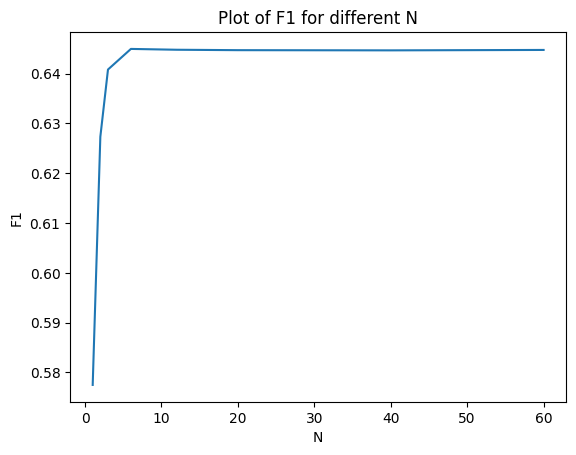

[0.5774750952654311, 0.6273229612061337, 0.6408287423299375, 0.6449700152791167, 0.6448037762310224, 0.6447198825178454, 0.6446807371661192, 0.6447646171190375]


In [34]:
plt.plot(K_list, K_score)
plt.xlabel('N') #Подпись для оси х
plt.ylabel('F1') #Подпись для оси y
plt.title('Plot of F1 for different N') #Название
plt.show()
print(K_score)

<span style="color:orange">
Из графика видно что, можно сократить 56 компонент без потери качества))))))

In [35]:
k = 5

pca_1 = PCA(n_components=k)
pca_1.fit(X_train)
X_train_pca = pca_1.transform(X_train)

pca_2 = PCA(n_components=k)
pca_2.fit(X_train_scaled)
X_train_s_pca = pca_2.transform(X_train_scaled)

pca_3 = PCA(n_components=k)
pca_3.fit(X_test)
X_test_pca = pca_3.transform(X_test)

pca_4 = PCA(n_components=k)
pca_4.fit(X_test_scaled)
X_test_s_pca = pca_4.transform(X_test_scaled)

## Обучение классификаторов на данных, трансформированных с помощью PCA

Обучим те же классификаторы на трансформированных с помощью PCA данных. Подберите оптимальные значения исследуемых гиперпараметров для новых данных. Постройте график среднего значения качества по кросс-валидации алгоритма при заданном значении гиперпараметра, на котором также отобразите доверительный интервал.

Что вы можете сказать о получившихся графиках? Какой алгоритм справился лучше? Какой быстрее? Почему?

<span style="color:orange">
Построение модели KNN на нешкалированных признаках после PCA.

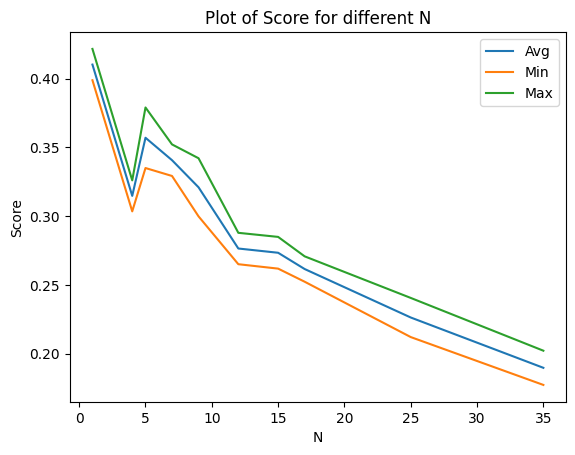

{'n_neighbors': 1}
Test score is: 1.0
Time fit is: 0.009809589385986328


In [52]:
KNN_train_res(X_train_pca, y_train)

<span style="color:orange">
Построение модели KNN на шкалированных признаках после PCA.

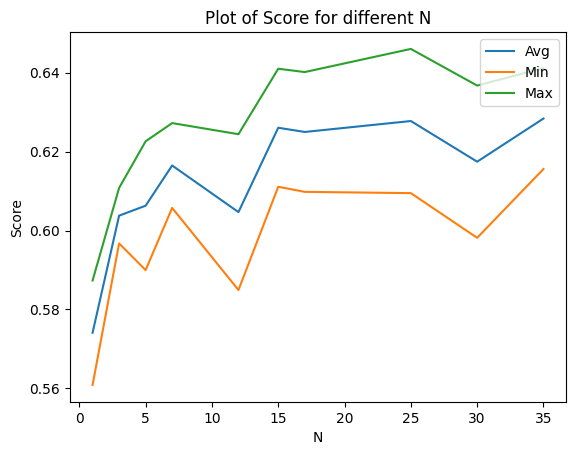

{'n_neighbors': 35}
Test score is: 0.6514059253038453
Time fit is: 0.010137224197387695


In [37]:
KNN_train_res(X_train_s_pca, y_train)

<span style="color:orange">
Построение модели tree на нешкалированных признаках после PCA.

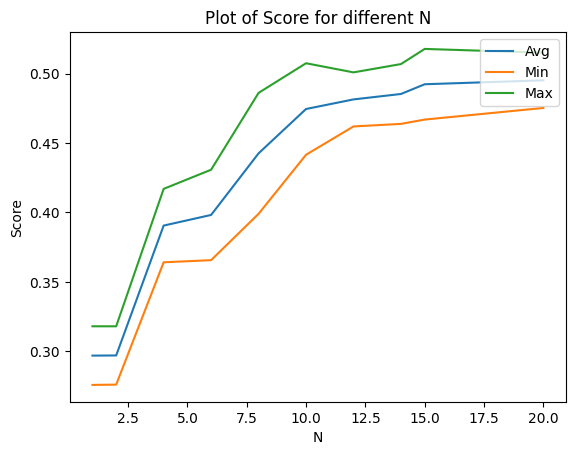

{'max_depth': 20}
Test score is: 0.8652681832775719
Time fit is: 0.0613957405090332


In [38]:
TREE_train_res(X_train_pca, y_train)

<span style="color:orange">
Построение модели tree на шкалированных признаках после PCA.

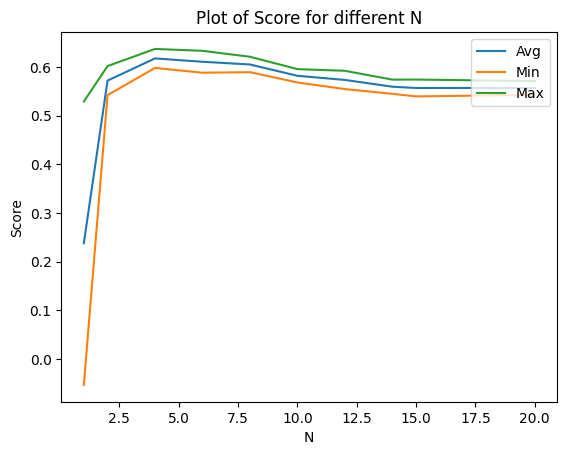

{'max_depth': 4}
Test score is: 0.635342842508047
Time fit is: 0.021172571182250976


In [39]:
TREE_train_res(X_train_s_pca, y_train)

<span style="color:orange">

### KNN ###
Не шкалированные.<br/>
{'n_neighbors': 1}<br/>
Test score is: 1.0<br/>
Time fit is: 0.009659528732299805<br/>

Шкалированные.<br/>
{'n_neighbors': 17}<br/>
Test score is: 0.6670018934660229<br/>
Time fit is: 0.009738636016845704<br/>

### TREE ###
Не шкалированные.<br/>
{'max_depth': 20}<br/>
Test score is: 0.8660193053767815<br/>
Time fit is: 0.061322593688964845<br/>

Шкалированные.<br/>
{'max_depth': 4}<br/>
Test score is: 0.6347316373398358<br/>
Time fit is: 0.020851898193359374<br/>

### Итого ###
Время построения KNN меньше на порядок. Но точность хуже. Аномалия с нешкалированными данными.<br/>
Удивительно, но дерево на не шкалированных данных справилось даже лучше чем без PCA. 
Что кажется аномальным.


## Сравнение результатов

Сравните результаты полученные до трансформации данных с помощью PCA и после. Есть ли изменения динамики среднего значения качества по кросс-валидации алгоритма? Объясните почему?

<span style="color:orange">
В основном роль играют первые 5 параметров. <br/>
Время выполнения в основном зависит от гиперпараметров, так что явно определить зависимость от метода
PCA затруднительно. <br/>
По числам результат следующий: <br/>

KNN not scaled.<br/>
{'n_neighbors': 1} <br/>
Test score is: 1.0 <br/>
Time fit is: 0.010111093521118164 <br/>

{'n_neighbors': 1}<br/>
Test score is: 1.0<br/>
Time fit is: 0.009659528732299805<br/>

Аномалия в динамике качества. <br/>


KNN scaled <br/>
{'n_neighbors': 25} <br/>
Test score is: 0.6581411402198765 <br/>
Time fit is: 0.003240966796875 <br/>

{'n_neighbors': 17}<br/>
Test score is: 0.6670018934660229<br/>
Time fit is: 0.009738636016845704<br/>

Качество изменилось незначительно. <br/>


TREE not scaled <br/>
{'max_depth': 12} <br/>
Test score is: 0.798837394467623 <br/>
Time fit is: 0.03226466178894043 <br/>


{'max_depth': 20}<br/>
Test score is: 0.8660193053767815<br/>
Time fit is: 0.061322593688964845<br/>

Качество возросло. <br/>


TREE scaled <br/>
{'max_depth': 12} <br/>
Test score is: 0.7989621394661269 <br/>
Time fit is: 0.03189554214477539 <br/>

{'max_depth': 4}<br/>
Test score is: 0.6347316373398358<br/>
Time fit is: 0.020851898193359374<br/>

Качесвто упало. <br/>


## Тестирование всех модели

Протестируйте все построенные модели (в т.ч. с и без PCA трансформации) на данных, которые были отложены для теста (их должно было остаться 40%). Не забудьте про все необходимые преобразования.

<span style="color:orange">

### KNN ###

In [40]:
def show_test_res(y_test, y_pred, time_all):
    Ac = accuracy_score(y_test, y_pred)
    print('Accuracy_score:', Ac)
    print('F1 binary:', f1_score(y_test, y_pred, average='binary'))
    print('Recall:', recall_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred))
    
    
    print('Time of algorithm:', time_all)


def KNN_result(X_train, y_train, X_test, neighbours):
    current_time = time.time()
    
    knn_best = KNeighborsClassifier(n_neighbors=neighbours)
    Model_best = knn_best.fit(X_train, y_train)
    y_pred = Model_best.predict(X_test)
    
    time_all = time.time() - current_time
    y_pred_proba = Model_best.predict_proba(X_test)

    show_test_res(y_test, y_pred, time_all)
    svc_disp = scikitplot.metrics.plot_roc(y_test, y_pred_proba)

Accuracy_score: 0.7010107597000326
F1 binary: 0.41293213828425096
Recall: 0.41532517707662586
Precision: 0.4105665181413113
Time of algorithm: 0.425243616104126


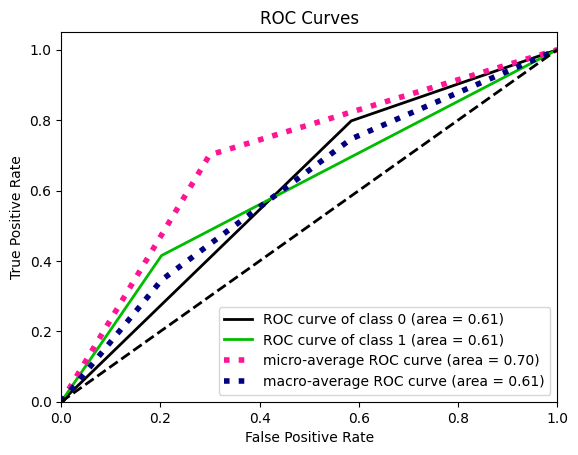

In [41]:
KNN_result(X_train, y_train, X_test, 1)

Accuracy_score: 0.8200195630909684
F1 binary: 0.6120871398453971
Recall: 0.5608499678042499
Precision: 0.6736272235112142
Time of algorithm: 0.4238319396972656


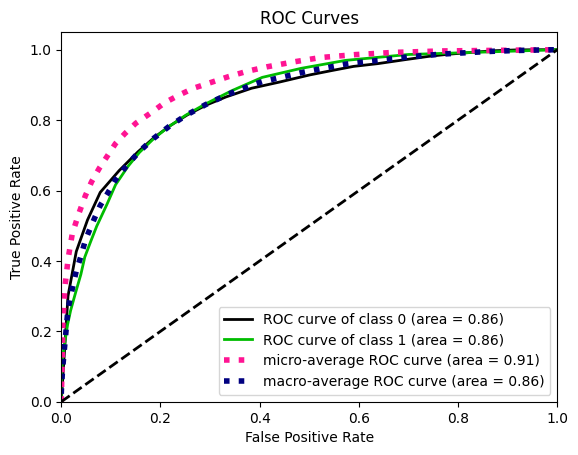

In [42]:
KNN_result(X_train_scaled, y_train, X_test_scaled, 25)

<span style="color:orange">

### KNN PCA K=5 ###

Accuracy_score: 0.7024779915226605
F1 binary: 0.39828552588196503
Recall: 0.38892466194462333
Precision: 0.4081081081081081
Time of algorithm: 0.24774909019470215


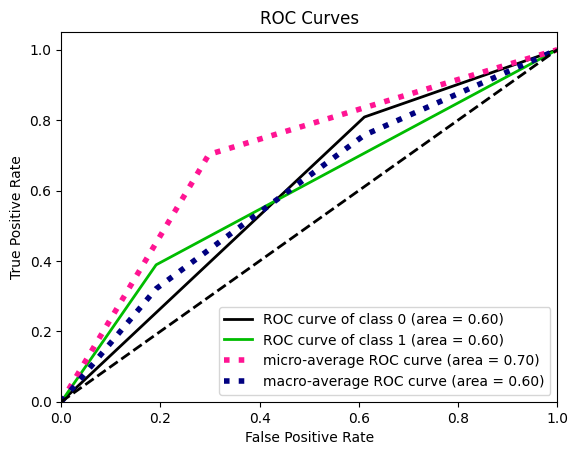

In [43]:
KNN_result(X_train_pca, y_train, X_test_pca, 1)

Accuracy_score: 0.831105314639713
F1 binary: 0.6375087473757872
Recall: 0.5866065679330328
Precision: 0.6980842911877395
Time of algorithm: 0.39978528022766113


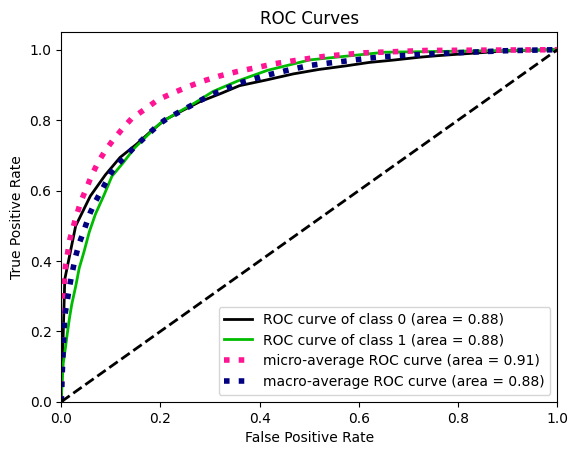

In [44]:
KNN_result(X_train_s_pca, y_train, X_test_s_pca, 25)

<span style="color:orange">

### Tree ###

In [45]:
def TREE_result(X_train, y_train, X_test, depth):
    current_time = time.time()
    
    tree_best = DecisionTreeClassifier(criterion='gini', max_depth=depth)
    Model_best = tree_best.fit(X_train, y_train)
    y_pred = Model_best.predict(X_test)
    
    time_all = time.time() - current_time
    y_pred_proba = Model_best.predict_proba(X_test)

    show_test_res(y_test, y_pred, time_all)
    svc_disp = scikitplot.metrics.plot_roc(y_test, y_pred_proba)

Accuracy_score: 0.830453211607434
F1 binary: 0.6433470507544582
Recall: 0.6039922730199614
Precision: 0.6881878209831255
Time of algorithm: 0.05333876609802246


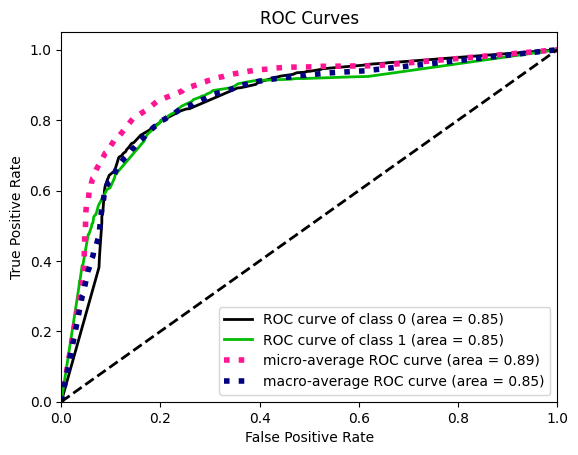

In [46]:
TREE_result(X_train, y_train, X_test, 12)

Accuracy_score: 0.8268666449298989
F1 binary: 0.632016632016632
Recall: 0.5872504829362524
Precision: 0.6841710427606902
Time of algorithm: 0.041967153549194336


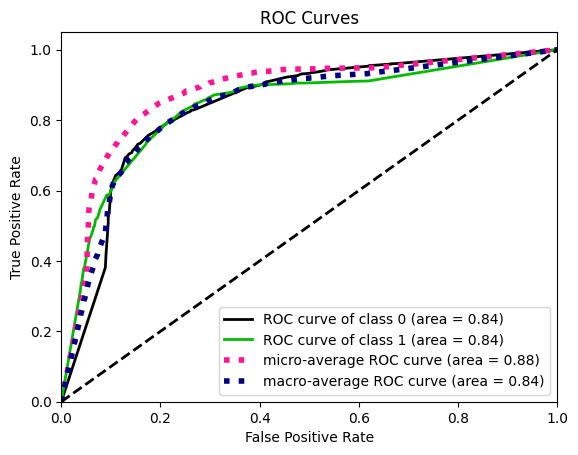

In [47]:
TREE_result(X_train_scaled, y_train, X_test_scaled, 12)

<span style="color:orange">

### TREE PCA K=5 ###

Accuracy_score: 0.791979132702967
F1 binary: 0.44857389801210024
Recall: 0.33419188667095945
Precision: 0.6819973718791065
Time of algorithm: 0.06500673294067383


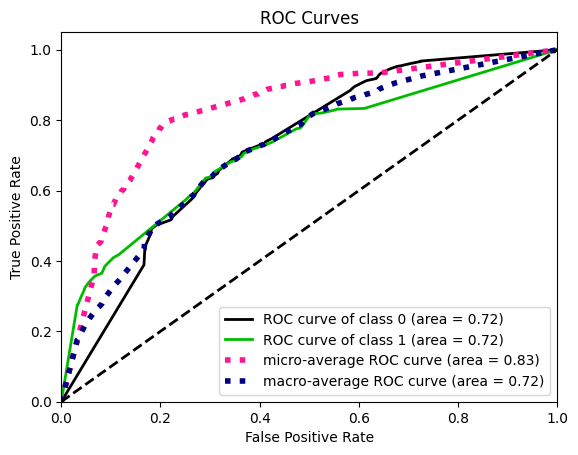

In [48]:
TREE_result(X_train_pca, y_train, X_test_pca, 12)

Accuracy_score: 0.7885555917835018
F1 binary: 0.55444864307798
Recall: 0.519639407598197
Precision: 0.5942562592047128
Time of algorithm: 0.06253504753112793


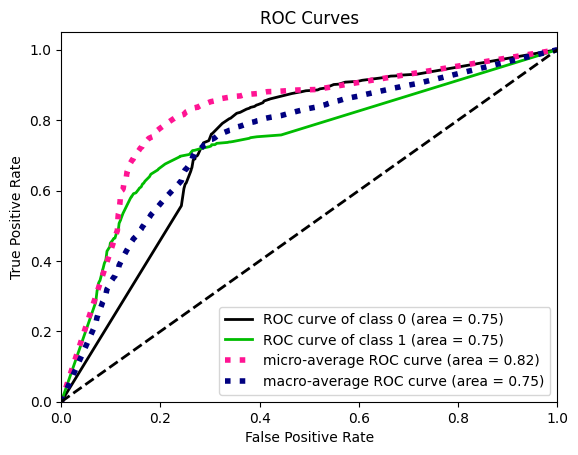

In [49]:
TREE_result(X_train_s_pca, y_train, X_test_s_pca, 12)

<span style="color:orange">

### Итого по работе ###
Лучше всего справилось дерево на нешкалированных признаках. С результатом  F1 = 0.634. Особая 
разница по времени с PCA незаметна. Вероятнее всего мало данных. Дерево в целом лучше справилось с
задачей. Шкалирование данных серьёзным образом повышает точность модели.